<center>
    <h1>Image Deblurring</h1>
    <h2>Deep Learning - 10 June 2022</h2>
    <h3>Riccardo Spolaor (0001032802)</h3>
    <h4>Email: riccardo.spolaor@studio.unibo.it</h4>
</center>

# Assignment
## Task 

The task consists of creating a deep learning model to detect hate speech or offensive language in texts. Try to build a pipeline which is able to perform the task and evaluate the results obtained. Make sure to test the model in order to prove robustness and lack of overfitting. 

The metric you will need to use to evaluate the results is the *MSE*. The metrics will be evaluated on the reconstructed images, so provide a way to check the results on a batch composed of original images and reconstructed images.

## Dataset
The dataset is built starting from *CIFAR-10* images collection. Feel free to further split the data to build a validation set, if needed. The split into different data split is left to you, perform it as you like, making sure it is meaningful.

### Dataset creation - DO NOT MODIFY

In [1]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

def getDataset():
    (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
    normalize = lambda x: x/x.max()
    x_train = normalize(x_train)
    x_test = normalize(x_test)
    createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
    return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

# Solution

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

## Data visualization

The train and test datasets containing the blurred images (`x_train` and `x_test`) and the corresponding target images (`y_train`, `y_test`) are generated through the provided `getDataset` function and their shapes are shown.

In [3]:
(x_train, y_train), (x_test, y_test) = getDataset()

In [4]:
print(f'The shape of the x_train dataset is: {x_train.shape}')
print(f'The shape of the y_train dataset is: {y_train.shape}')

print(f'The shape of the x_test dataset is: {x_test.shape}')
print(f'The shape of the y_test dataset is: {y_test.shape}')

The shape of the x_train dataset is: (50000, 32, 32, 3)
The shape of the y_train dataset is: (50000, 32, 32, 3)
The shape of the x_test dataset is: (10000, 32, 32, 3)
The shape of the y_test dataset is: (10000, 32, 32, 3)


In [5]:
def plot_images_comparison(images_dataset_1, images_dataset_2, main_title, 
                           title_1, title_2):
    fig = plt.figure(figsize=(16,8))
    
    fig.suptitle(main_title, fontsize=14)

    grid1 = ImageGrid(fig, 121, (3, 3), axes_pad=.05, share_all=True)
    grid2 = ImageGrid(fig, 122, (3, 3), axes_pad=.05, share_all=True)

    grid1.axes_all[1].set_title(title_1)
    grid2.axes_all[1].set_title(title_2)
    
    for ax, im in zip(grid1, images_dataset_1):
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    for ax, im in zip(grid2, images_dataset_2):
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Thereafter, the blurred images of the train dataset `x_train` are visually compared to their real counterparts in `y_train`. We can observe a `Warning` that expresses that the images of `x_train` are going to be clipped to a valid range (in this case $[0, 1]$). This indicates that the *gaussian blur* and *gaussian noise* addition has brought some pixels out of the normalized range of the images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


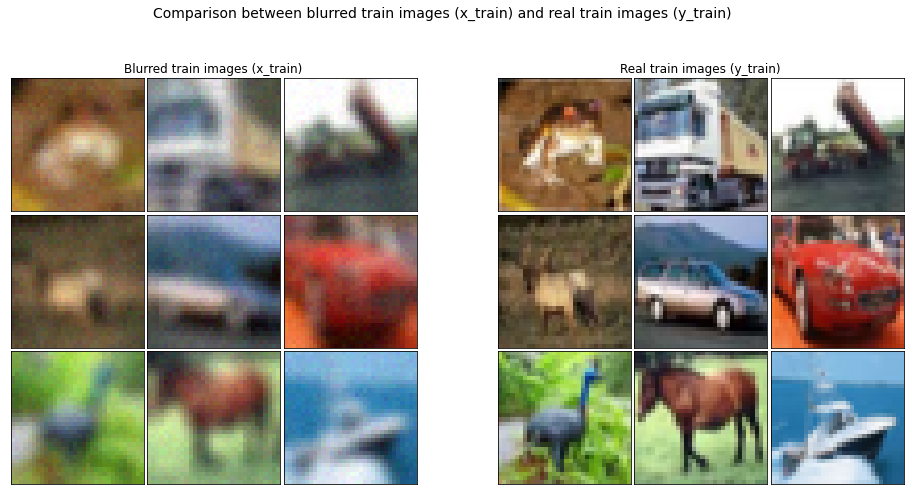

In [6]:
plot_images_comparison(
    x_train, y_train,
    'Comparison between blurred train images (x_train) and real train images (y_train)', 
    'Blurred train images (x_train)', 'Real train images (y_train)'
)

## Model building process
### Previous attempts

Three different models have been proposed before the implementation of the final one. The successive implementations of the different architectures have been considered in an incremental way, by trying to exploit the perks of the previous models while adding useful attributes. This procedure helped decreasing the value of the considered metric, namely the *Mean Squared Error (MSE)*. The train data (`x_train`, `y_train`) was further split to obtain a validation dataset. Its definition has been the same for all the models and its purpose will be explained in the next sections of the notebook.

The previous models and their characteristics are listed below. I developed in order:
1. a simple **Autoencoder** - Autoencoders are used in literature for data denoising operations. The idea behind this first model was to try to exploit possible regularities of the features of the images in order to encode an internal representation of them. The encoding process was obtained by using a couple of *convolutions* each followed by *max pooling* operations. The *channels* of the obtained convolutions were doubled at each decrease in spatial dimensionality. The encodings were then upsampled and subjected once again to convolutions, while their *channels* were decreased until the shape of the original input was restored, representing the denoised image. Using this process I managed to reach a *MSE* value of $\approx 0.0044$ with $20$ *epochs* on the validation set during the train process and $16,675$ parameters.

2. an **Autoencoder** using a **long skip connections** - This new model has been built by adding to the autoencoder a *skip connection for residual learning* subtracting the image obtained after the decoding process from the input image itself. The reasoning behind this addition was that reconstruction of the image from the encoded representation could suffer information loss and that injecting information of the original input image to the decoding could help the process. The encoding and decoding processes had been carried out while respectively increasing and decreasing the channels of the input images through convolutions as before. Although the spatial dimension of the input has been kept constant for the whole process evading downsampling and upsampling operations. This choice has been made because I supposed that reducing the spatial shape of the input could have generated information loss and the original dimension of the images was particularly limited. Both these implementation have been significative and a *MSE* value of $\approx 0.0032$ was reached on the validation set with $20$ training *epochs* $124,867$ parameters.

3. **DnCNN** [[1]](https://arxiv.org/abs/1608.03981) - This model proposal found in literature has a different approach that does not exploit any autoencoding mechanism. Nonetheless, the previous hypothesis regarding the efficiency of using a *long skip connection* for *residual learning* and to not apply down-sampling of the spatial dimension of the input image during the *feature learning* process are considered once again. The model aims at learning the noise of a noisy image by applying a long series of subsequent convolutions, each followed by *batch normalization* to enhance the training performance. The learned noise is finally subtracted from the input image thanks to a *long skip connection*. The original model was originally proposed for image denoising application and not image deblurrying. Although, the fact that the model uses a discriminative approach, where the learned noisy information was actually removed from the original image led me to believe that good results could be obtained even for deblurrying operations. A *MSE* value of $\approx 0.0026$ was reached on the validation set with $20$ training *epochs* and $631,299$ parameters. The result led me primarily to understand the importance of an insistent *feature learning* process to obtain better solutions for the specific problem.


| Model                                  | Parameters | MSE    |
| :------------------------------------- | ---------: | -----: |
| Autoencoder                            | 16,675     | 0.0044 |
| Autoencoder with long skip connections | 124,867    | 0.0032 |
| DnCNN                                  | 631,299    | 0.0026 |

### Selected model
The architecture actually used for the solution of the task was found in literature and it is the **RIDNet** model [[2]](https://arxiv.org/abs/1904.07396). Once again, this model has been selected by trying to exploit characteristics found in the previous tested architectures. In particular, it takes from the second model the use of *convolutions* for *feature extraction and learning*, while not performing down-sampling of the spatial dimension of the input and it also uses *skip connections* for *residual learning*. Furthermore it does not work as an *autoencoder* and it performs an important part of *feature learning* like the third model does. Once again the model was proposed by the authors for denoising tasks of images. Although, the fact that it has been tested by the authors on both synthetic and natural noise and the fact that it followed a similar approach to *DnCNN* in order to reconstruct and predict the real non-noisy images after the *feature learning* phase led me to believe that it could achieve good results even in deblurrying tasks. Moreover, the decision to try this model was also guided by the fact that it was compared to architectures similar to *DnDNN* in the paper and it performed better.

The main perks of this model compared to the previous ones are that *short skip connections* are applied in the *feature learning* process blocks and *feature attention* is introduced to underline the important lerned features of the blocks. 

####  Model structure
Albeit the structure of the model is slightly more complex than the previous ones, it is not particularly difficult to understand or implement.


In [8]:
def eam(input_layer, channels, reduction_ratio=8):
    # First branch dilated convolutions
    x = layers.Conv2D(channels, 3, dilation_rate=1, padding='same',
                      activation='relu')(input_layer)
    x = layers.Conv2D(channels, 3, dilation_rate=2, padding='same',
                      activation='relu')(x)

    # Second branch dilated convolutions
    y = layers.Conv2D(channels, 3, dilation_rate=3, padding='same',
                      activation='relu')(input_layer)
    y = layers.Conv2D(channels, 3, dilation_rate=4, padding='same',
                      activation='relu')(y)

    # Concatenate the branches, apply a convolution, add residual connection
    z = layers.Concatenate(axis=-1)([x,y])
    z = layers.Conv2D(channels, 3, padding='same')(z)
    z = layers.Add()([z, input_layer])
    act_b1 = layers.Activation('relu')(z)

    # Convolve, add residual with the result of the previous block and activate 
    x = layers.Conv2D(channels, 3, padding='same', activation='relu')(act_b1)
    x = layers.Conv2D(channels, 3, padding='same')(x)
    x = layers.Add()([x, act_b1])
    act_b2 = layers.Activation('relu')(x)

    # Convolve, add residual with the result of the previous block and activate
    x = layers.Conv2D(channels, 3, padding='same',activation='relu')(act_b2)
    x = layers.Conv2D(channels, 3, padding='same',activation='relu')(x)
    x = layers.Conv2D(channels, 1)(x)
    x = layers.Add()([x, act_b2])
    act_b3 = layers.Activation('relu')(x)

    # Apply squeeze and excitation attention
    att = layers.GlobalAveragePooling2D(keepdims=True)(act_b3)
    h_d = layers.Conv2D(channels // reduction_ratio, 3, padding='same', 
                        activation='relu')(att)
    h_u = layers.Conv2D(channels, 3, padding='same',activation='sigmoid')(h_d)
    output_layer = layers.Multiply()([h_u, act_b3])

    return output_layer

In [9]:
def ridnet(input_shape, channels=32):
    input_layer = layers.Input(input_shape)
    
    # Extract features
    feature_extraction = layers.Conv2D(channels, 3, padding='same')(input_layer)
    
    # Learn features with residual connections blocks
    eam_1 = eam(feature_extraction, channels)
    eam_2 = eam(eam_1, channels)
    eam_3 = eam(eam_2, channels)
    eam_4 = eam(eam_3, channels)
    
    # Reconstruct and add residual connections
    add_1 = layers.Add()([eam_4, feature_extraction])
    act = layers.Activation('relu')(add_1)
    reconstruction = layers.Conv2D(3, 3, padding='same')(act)
    add_2 = layers.Add()([reconstruction, input_layer])
  
    # Build the model
    model = Model(input_layer, add_2)
    return model

model = ridnet(x_train.shape[1:])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                              

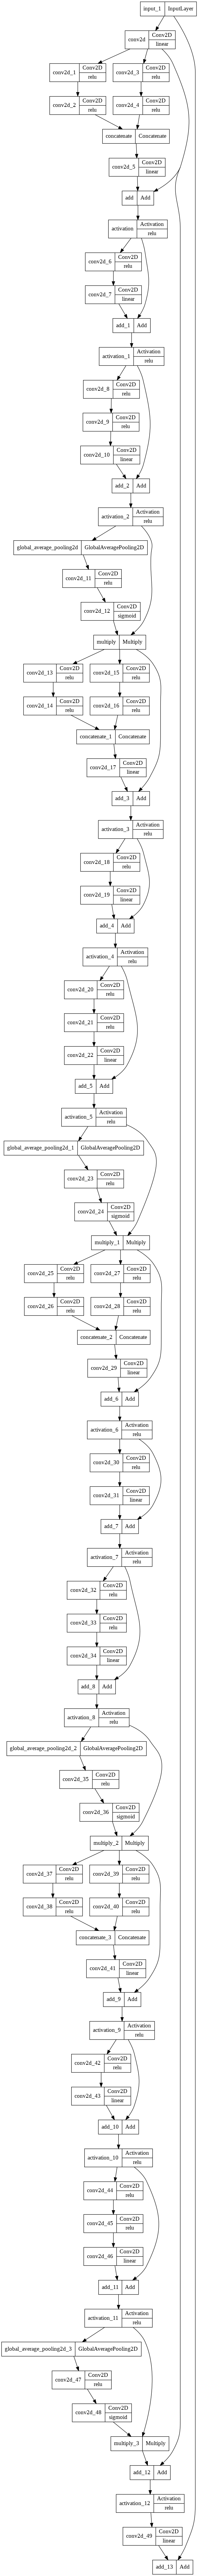

In [11]:
plot_model(model, show_layer_activations=True)

In [12]:
one_norm_loss = lambda y_true, y_pred: tf.norm(y_true - y_pred, ord=1, axis=-1)

In [13]:
adam = Adam(0.001, beta_1=0.1)
model.compile(optimizer=adam, loss=one_norm_loss, metrics=["mse"])

In [14]:
WEIGHTS_DIRECTORY_PATH = './weights/'
WEIGHTS_FILE_PATH = os.path.join(WEIGHTS_DIRECTORY_PATH, 'weights.h5')

os.makedirs(os.path.dirname(WEIGHTS_DIRECTORY_PATH), exist_ok=True)

In [15]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_mse',
    filepath=WEIGHTS_FILE_PATH,
    save_best_only=True,
    save_weights_only=True
)

In [16]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, 
                    batch_size=64, callbacks=[model_checkpoint])

Epoch 1/50
625/625 [==============================] - 74s 109ms/step - loss: 0.1448 - mse: 0.0047 - val_loss: 0.1268 - val_mse: 0.0036
Epoch 2/50
625/625 [==============================] - 68s 108ms/step - loss: 0.1161 - mse: 0.0031 - val_loss: 0.1088 - val_mse: 0.0027
Epoch 3/50
625/625 [==============================] - 68s 109ms/step - loss: 0.1097 - mse: 0.0027 - val_loss: 0.1081 - val_mse: 0.0027
Epoch 4/50
625/625 [==============================] - 67s 108ms/step - loss: 0.1070 - mse: 0.0026 - val_loss: 0.1049 - val_mse: 0.0025
Epoch 5/50
625/625 [==============================] - 68s 108ms/step - loss: 0.1052 - mse: 0.0025 - val_loss: 0.1051 - val_mse: 0.0025
Epoch 6/50
625/625 [==============================] - 68s 108ms/step - loss: 0.1041 - mse: 0.0025 - val_loss: 0.1047 - val_mse: 0.0025
Epoch 7/50
625/625 [==============================] - 68s 108ms/step - loss: 0.1037 - mse: 0.0025 - val_loss: 0.1197 - val_mse: 0.0034
Epoch 8/50
625/625 [==============================] - 6

In [17]:
def plot_training_history(key):
    plt.plot(history.history[key])
    plt.plot(history.history[f'val_{key}'])
    plt.title(f'Model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

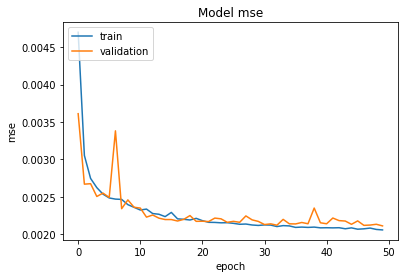

In [18]:
plot_training_history('mse')

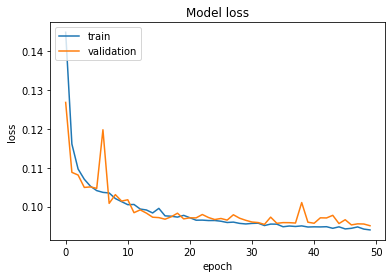

In [20]:
plot_training_history('loss')

In [19]:
model.load_weights(WEIGHTS_FILE_PATH)

In [21]:
predictions = model.predict(x_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


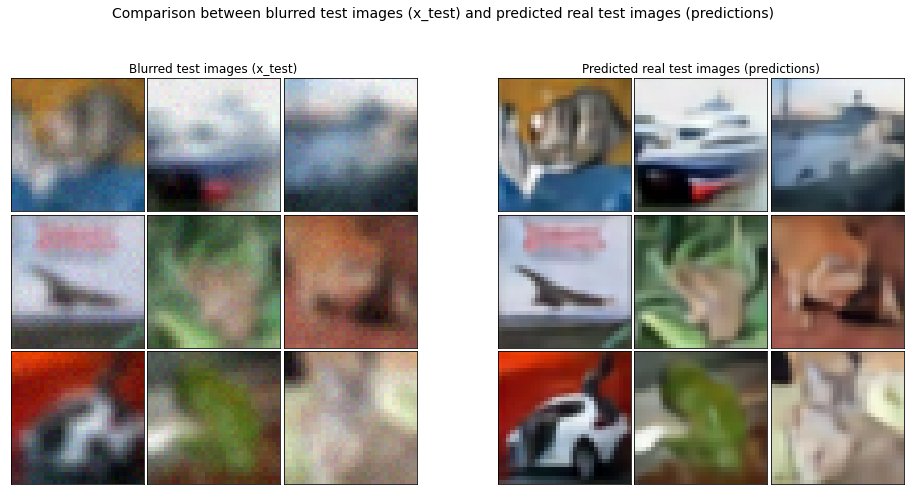

In [22]:
plot_images_comparison(
    x_test, predictions,
    'Comparison between blurred test images (x_test) and predicted real test images (predictions)', 
    'Blurred test images (x_test)', 'Predicted real test images (predictions)'
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


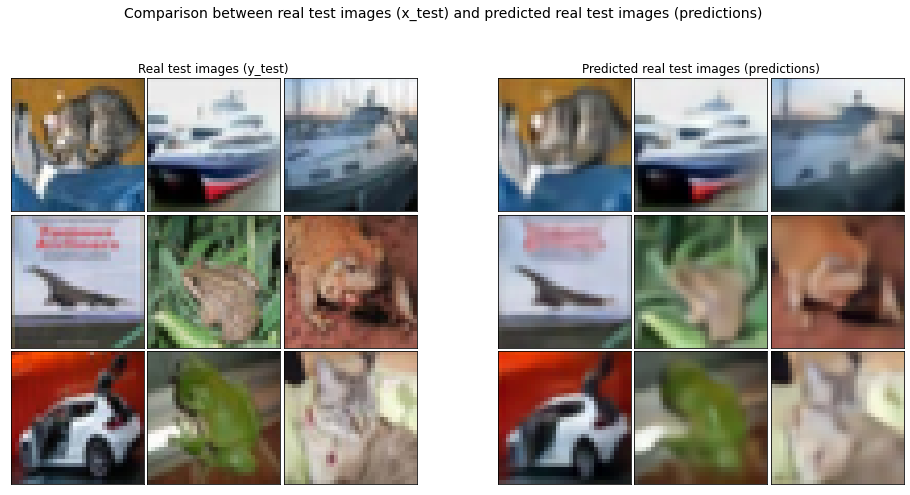

In [23]:
plot_images_comparison(
    y_test, predictions,
    'Comparison between real test images (x_test) and predicted real test images (predictions)', 
    'Real test images (y_test)', 'Predicted real test images (predictions)'
)

In [24]:
mse = MeanSquaredError()
result = mse(y_test, predictions).numpy()
print('Mean squared error between the images reconstructed by the model ' + 
      '(predictions) and the real images of the test set (y_test):') 
print(result)

Mean squared error between the images reconstructed by the model (predictions) and the real images of the test set (y_test):
0.0021152266
